<a href="https://colab.research.google.com/github/s1c5000/kaggle/blob/main/PortoSeguro/1_1_Data_Preparation_Porto_Seguro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


캐글 필사3

* 원본 : https://www.kaggle.com/bertcarremans/data-preparation-exploration

In [ ]:
# kaggle json
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction

  0% 0.00/2.12M [00:00<?, ?B/s]
100% 2.12M/2.12M [00:00<00:00, 69.8MB/s]
 30% 9.00M/30.0M [00:01<00:04, 4.78MB/s]
100% 30.0M/30.0M [00:01<00:00, 17.3MB/s]
 92% 41.0M/44.4M [00:02<00:00, 7.07MB/s]
100% 44.4M/44.4M [00:03<00:00, 15.4MB/s]


In [ ]:
!unzip '/content/train.csv.zip'
!unzip '/content/test.csv.zip'
!unzip '/content/sample_submission.csv.zip'

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


# Introduction
이 노트북은 PorteSeguro 대회의 데이터에서 좋은 통찰력을 얻는 것을 목표로합니다. 그 외에도 모델링을 위해 데이터를 준비하는 몇 가지 팁과 요령을 제공합니다. 노트북은 다음과 같은 주요 섹션으로 구성됩니다.


* Visual inspection of your data
* Defining the metadata
* Descriptive statistics
* Handling imbalanced classes
* Data quality checks
* Exploratory data visualization
* Feature engineering
* Feature selection
* Feature scaling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)

import warnings
warnings.filterwarnings('ignore')

#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

## 첫눈에 보는 데이터

다음은 대회 데이터 설명에서 발췌한 내용입니다.

* 유사한 그룹에 속하는 feature들은 태그가 지정됩니다 ( ex: ind, reg, car , calc)
* feature이름에는 이진기능을 나타내는 접미사 bin과 범주 기능을 나타내는 cat이 포함됩니다.
* 이러한 지정이 없는 feature들은 연속형이거나 순서형 입니다.
* -1은 관측치에서 feature가 누락되었다는 뜻입니다.
* target은 해당보험 계약자에대한 청구가 점수되었는지 여부를 나타냅니다.

첫번째 행과 마지막행들을 빠르게 확인해보겠습니다.

In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


우리는 이러한 사실을 볼 수 있습니다.
* binary variables
* 범주값이 정수인 categorical variables 
* 정수 또는 float값을 가진 기타변수
* 결측값을 나타내는 -1
* target값 ID값

train의 행과 열의 수를 보겠습니다

In [ ]:
train.shape

(595212, 59)

59 개의 변수와 595.212 개의 행이 있습니다.     
테스트 데이터에 동일한 수의 변수가 있는지 살펴 보겠습니다.  
훈련 데이터에 중복 된 행이 있는지 살펴 보겠습니다.

In [ ]:
train.drop_duplicates()
train.shape

(595212, 59)

중복이 없는것을 확인 할 수 있습니다

In [ ]:
test.shape

(892816, 58)

test세트에서 하나의 변수가 누락되었지만, 이것은 target변수입니다.  
이제 우리가 기진 각 유형의 변수 수를 조사해 보겠습니다.  

나중에 14개의 범주형 변수에 대한 더미변수를 만들 수 있습니다. bin 변수는 이미 바이너리이며 더미화가 필요하지않습니다

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

info메서드를 사용하면 데이터유형이 정수인지 float인지 알 수 있습니다. 데이터세트에 널값이 없습니다. 누락된 값을 -1로 표현해서 그렇습니다. 나중에 살펴보겠습니다

## metadata
데이터관리를 용이하게 하기위해 변수에 대한 메타정보를 DataFrame에 저장합니다. 이는 분석, 시각화 , 모델링 등을 위해 특정변수를 선택하려는 경우에 유용합니다.

다음을 저장할 것입니다.    
* role:input, id, target
* level:nominal, interval, ordinal, binary
* keep: True or False
* dtype:int, float, str

In [ ]:
data = []
for f in train.columns:
  if f =='target':
    role = 'target'
  elif f == 'id':
    role = 'id'
  else:
    role = 'input'
  
  if 'bin' in f or f=='target':
    level='binary'
  elif 'cat' in f or f == 'id':
    level = 'nominal' # 명목, 이름뿐인
  elif train[f].dtype == float:
    level='interval' # 간격
  elif train[f].dtype == int:
    level = 'ordinal'

  #id 빼고 keep을 True
  keep = True
  if f =='id':
    keep = False
  
  dtype = train[f].dtype

  f_dict={
      'varname' : f,
      'role' : role,
      'level': level,
      'keep' : keep,
      'dtype':dtype
  }
  data.append(f_dict)

# list안의 dict이 여러개들어간 값들도 DataFrame으로 바꿀수 있음
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [ ]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


삭제되지 않은 모든 norminal 변수를 추출하는 예

In [ ]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [ ]:
meta.query('(level == "nominal") and (keep)').index # query로 해본것

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

역할과 레벨별 변수의 수를 출력해보겠습니다

In [ ]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].count()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Descriptive statistics(기술통계)

describe메서드를 적용해 볼 수 있겠지만 범주형변수와 아이디 변수에 평균, std를 계산 하는 것은 의미가 없습니다. 나중에 범주형 변수를 시각적으로 확인해 보겠습니다.

메타파일 덕분에 기술 통계를 계산할 변수를 쉽게 선택할 수 있습니다. 명확하게 하기위해 데이터유형별로 이작업을 수행합니다

### interval variables

In [ ]:
v = meta[(meta.level == 'interval') & (meta.keep)].index # dtype이 float인것
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg variables
* ps_reg_03에만 누락된 값이 있습니다.
* 범위는 변수마다다 다릅니다. scaling(standardscaler)를 적용 할 수 있지만 사용하려는 classifier에 따라 다릅니다.  

car variables
* ps_car_12_and ps_car_15 에 누락된 값이있습니다.
* 다시말하지만 범위가 다르며 scaling을 적용할 수있습니다.  

calc variables
* 결측값 없음
* 최대값이 0.9이기때문에 일종의 비율 같습니다.
* 세게의 _calc 변수는 모두 유사한 분포를 같고있습니다.


전반적으로 interval(간격) 변수의 범위가 다소 작다는 것을 알 수 있습니다. 

### Ordinal variables

In [ ]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


* ps_car_11 만결측치가 있다.
* 다양한 범위를 처리하기위해 스케일링을 적용 할 수 있습니다.

### Binary variables

In [ ]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* train데이터의 target은 3.645%만이 1이다. 매우불균형 합니다.
* 평균으로부터 우리는 대부분의 변수에 대해 0이라는 것을 알 수 있습니다

## handling imbalanced classes
위에서 본 바와같이 target의 1 값은 0보다 매우 적습니다. 이로인해 정확도는 높지만 실제로는 쓸모없는 모델이 생성 될 수 있습니다. 이 문제를 처리하기위한 두가지 전략이있습니다

* target=1인 레코드 oversmapling
* target=0인 레코드 undersampling

훈련세트가 상당히 크기때문에 undersampling을 할 수 있습니다

In [ ]:
desired_apriori = 0.10

# target값당 인덱스
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# 언더 샘플링 비율과 target이 0 인 레코드 수를 계산합니다.
undersampling_rate = ((1-desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

#target = 0 인 레코드를 무작위로 선택합니다.
undersampled_idx = shuffle(idx_0, random_state = 37, n_samples=undersampled_nb_0)

# target = 1인 개수만큼 target=0인 레코드를 뽑아서 target=1인 레코드와 합친다. 이제 1:1 임
idx_list = list(undersampled_idx) + list(idx_1)

train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## Data Quality Checks

checking missing values

In [ ]:
vars_with_missing = []

for f in train.columns:
  missings = train[train[f] == -1][f].count()
  if missings > 0:
    vars_with_missing.append(f)
    missings_perc = missings/train.shape[0]

    print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


* ps_car_03_cat및 ps_car_05_cat에는 결측치가많습니다. 이러한 변수는 제거하는게 좋습니다.
* 결측값이 있는 다른 범주형 변수의 경우 결측값 -1을 그대로 둘 수 있습니다.
* ps_reg_03(continuous) 에 18%의 결측치가있습니다. 평균으로 대체하겠습니다.
* ps_car_11(ordinal) 에는 1개의 결측치가있습니다. 평균으로 교체하겠습니다
* ps_car_14(continuous)에는 7%의 결측치가있습니다. 평균으로 교체하겠습니다

In [ ]:
# drop
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False

In [ ]:
# simpleimputer는 axis변수 빼버림, axis = 0 일때와 동일하게작용,  행방향으로 변환할때는  FunctionTransformer 사용한다.
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mean_imp.fit_transform(train[['ps_car_11']]).ravel()

### categorical 변수의 cardinallity(변수에 있는 서로다른 값의 수)확인
카디널리티는 변수에있는 서로다른 값의 수 입니다. 나중에 범주형 변수에서 더미 변수를 만들것이므로 고유한 값이 많은 변수가 있는지 확인해야합니다. 이러한 변수는 많은 더미변수를 만듬으로 다르게 처리해야합니다.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
  dist_values = train[f].value_counts().shape[0]
  print('Variable {} has {} distinct values'.format(f, dist_values))


Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


ps_car_11_cat만이 많은 고유값을 가지고있습니다  


In [ ]:
train[['ps_car_11_cat','target']].groupby(by=train.ps_car_11_cat.name)[train.target.name].agg(['mean','count'])

,mean,count
ps_car_11_cat,,
1,0.108260,1247
2,0.103082,941
3,0.139078,1172
4,0.164966,588
5,0.113000,4646
...,...,...
100,0.138773,1679
101,0.108035,2601
102,0.097127,731


In [ ]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, # 인자로 train["ps_car_11_cat"] 넣음
                  tst_series=None, # test["ps_car_11_cat"]
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):

  '''
    trn_series : pd.Series로 범주 기능 학습
    tst_series : pd.Series로 범주 기능 테스트
    target : pd.Series로 대상
    min_samples_leaf (int) : 카테고리 평균을 고려할 최소 샘플
    smoothing (int) : 범주 형 평균과 이전의 균형을 맞추는 평활 효과
  '''
  assert len(trn_series) == len(target)
  assert trn_series.name == tst_series.name
  temp = pd.concat([trn_series, target], axis=1)
  # Compute target mean 
  averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"]) # trn_series.name = "ps_car_11_cat", ps_car_11_cat이 index가 된다.
  # Compute smoothing 분포를 나누는데 도움이된다.
  smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
  # 모든 타겟 데이터에 평균 기능 적용
  prior = target.mean()
  # 카운트가 클수록 full_avg가 덜 고려됩니다.
  averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
  averages.drop(["mean", "count"], axis=1, inplace=True)
  # Apply averages to trn and tst series
  # trn_series, averages 병합
  ft_trn_series = pd.merge(
      trn_series.to_frame(trn_series.name),
      averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
      on=trn_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  # pd.merge는 색인을 유지하지 않으므로 복원하십시오.
  ft_trn_series.index = trn_series.index 
  ft_tst_series = pd.merge(
      tst_series.to_frame(tst_series.name),
      averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
      on=tst_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  # pd.merge does not keep the index so restore it
  ft_tst_series.index = tst_series.index
  return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [ ]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# Exploratory Data visualization 탐색 적 데이터 시각화


## Categorical variables 범주형 변수
target =1 이고 범주형인 고객 비율을 살펴보겠습니다

<Figure size 432x288 with 0 Axes>

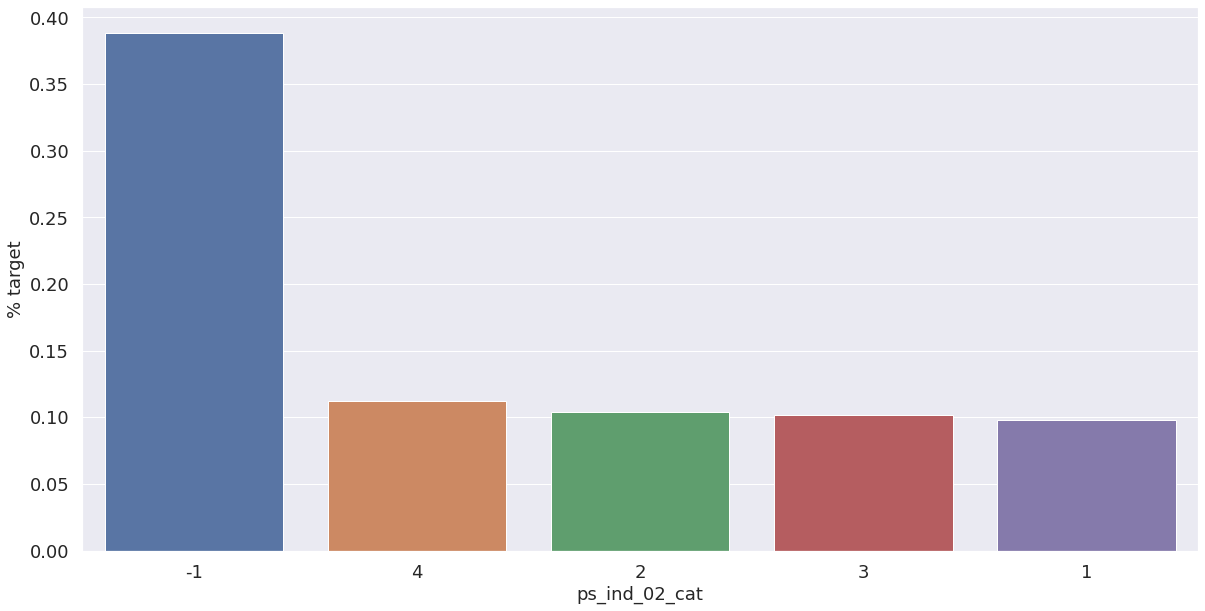

<Figure size 432x288 with 0 Axes>

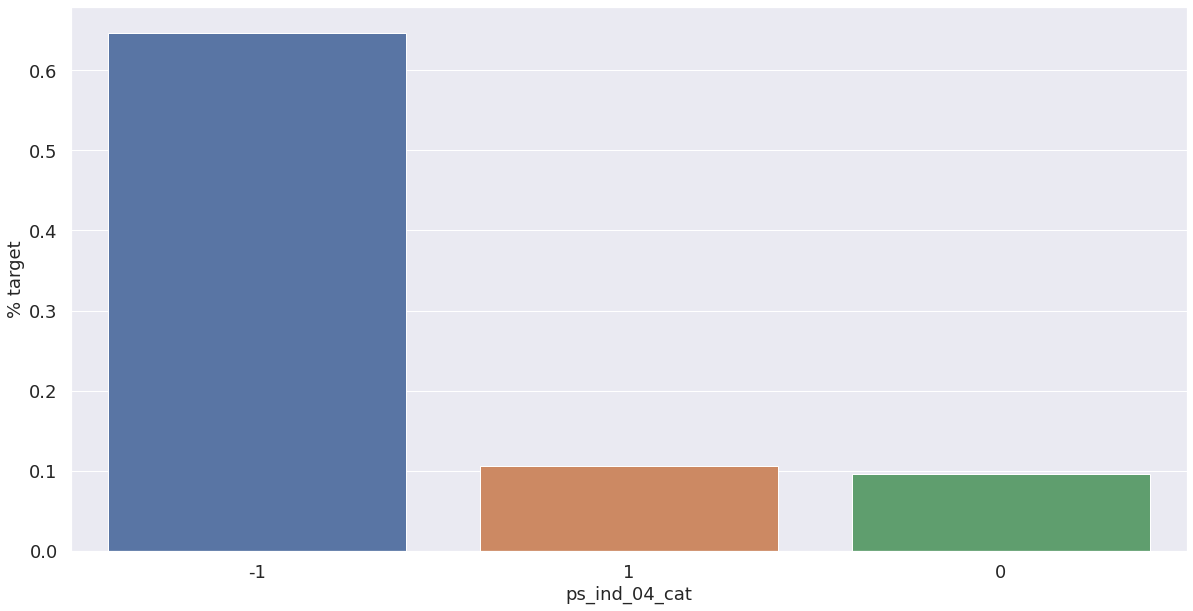

<Figure size 432x288 with 0 Axes>

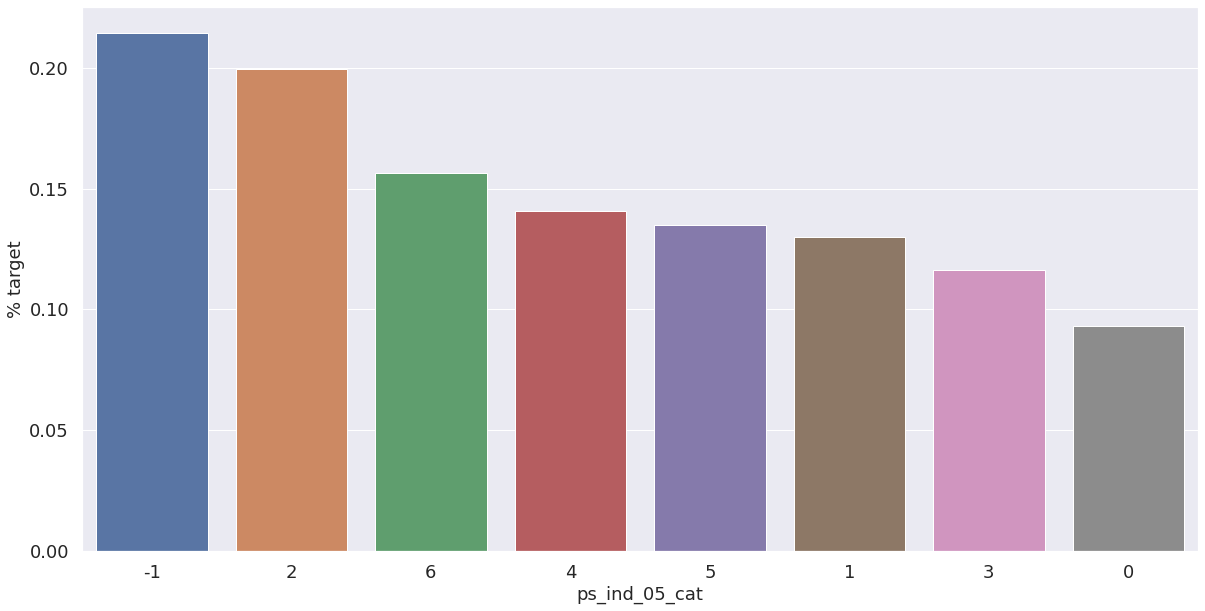

<Figure size 432x288 with 0 Axes>

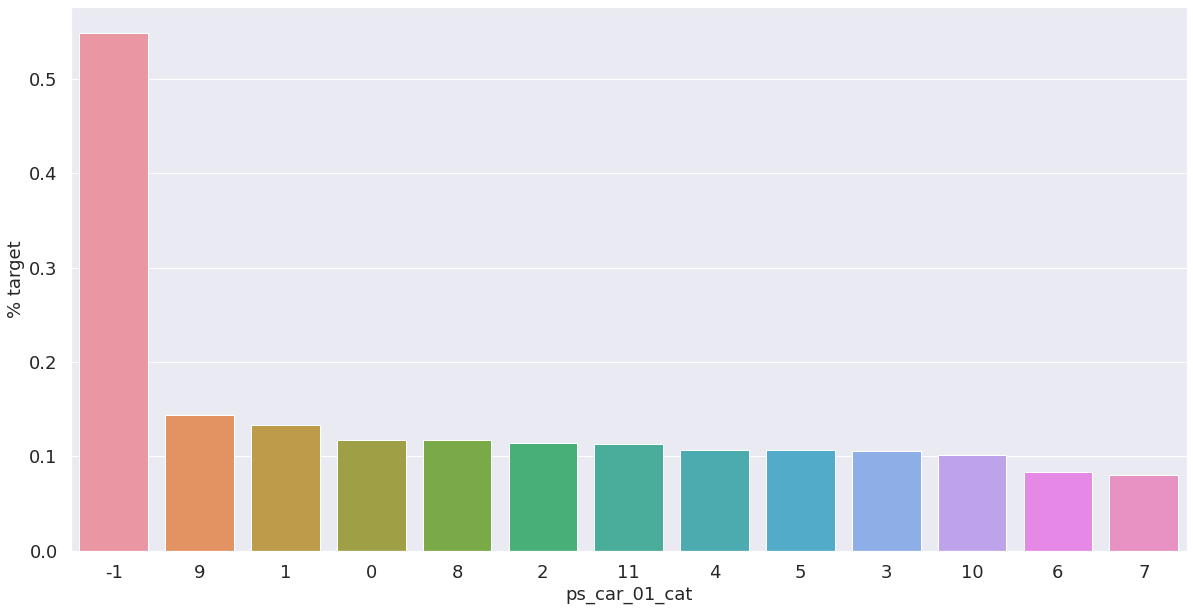

<Figure size 432x288 with 0 Axes>

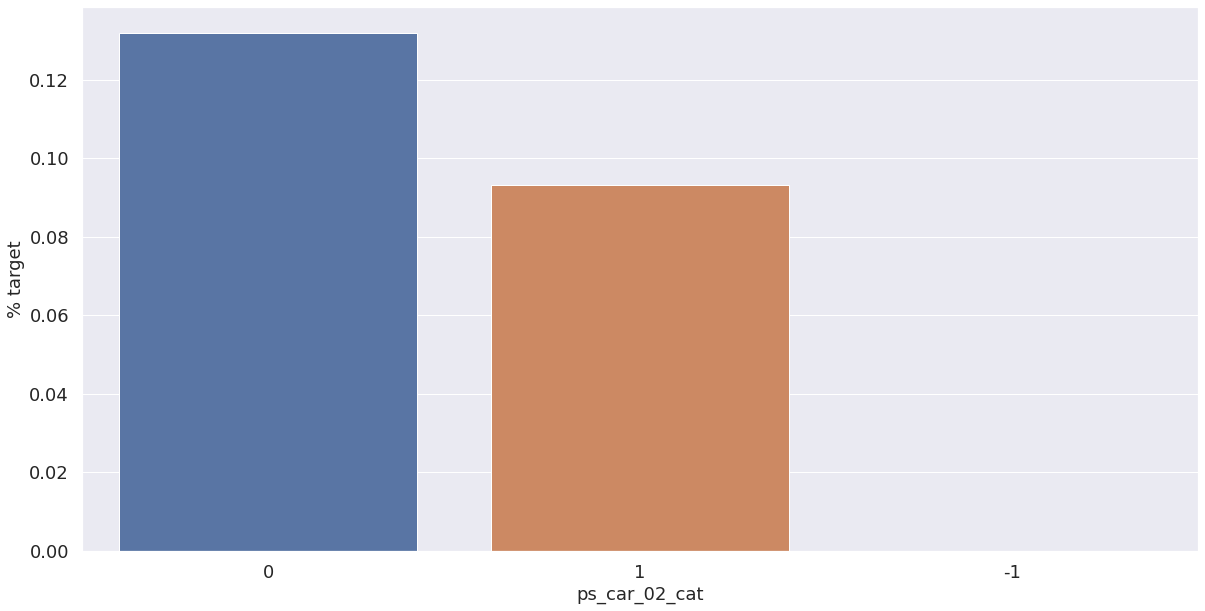

<Figure size 432x288 with 0 Axes>

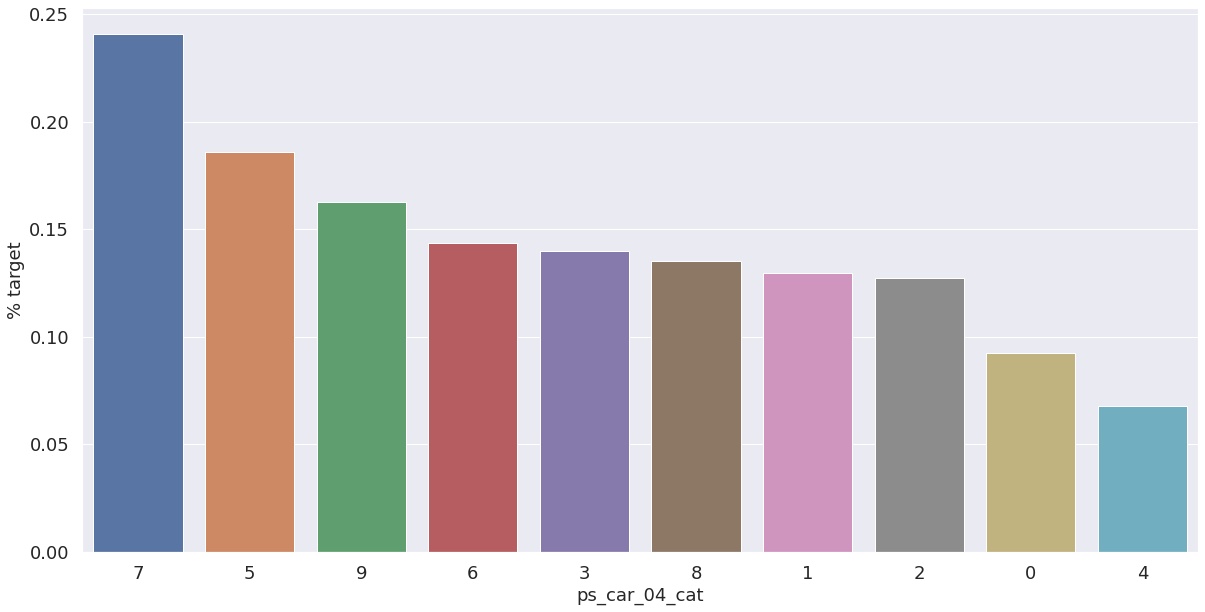

<Figure size 432x288 with 0 Axes>

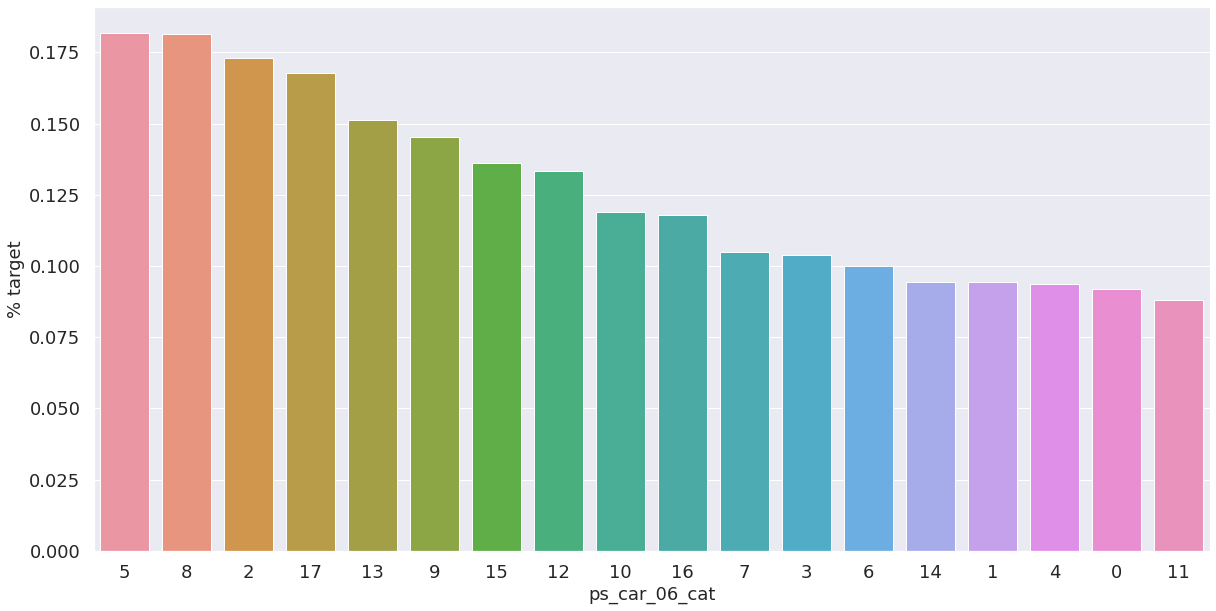

<Figure size 432x288 with 0 Axes>

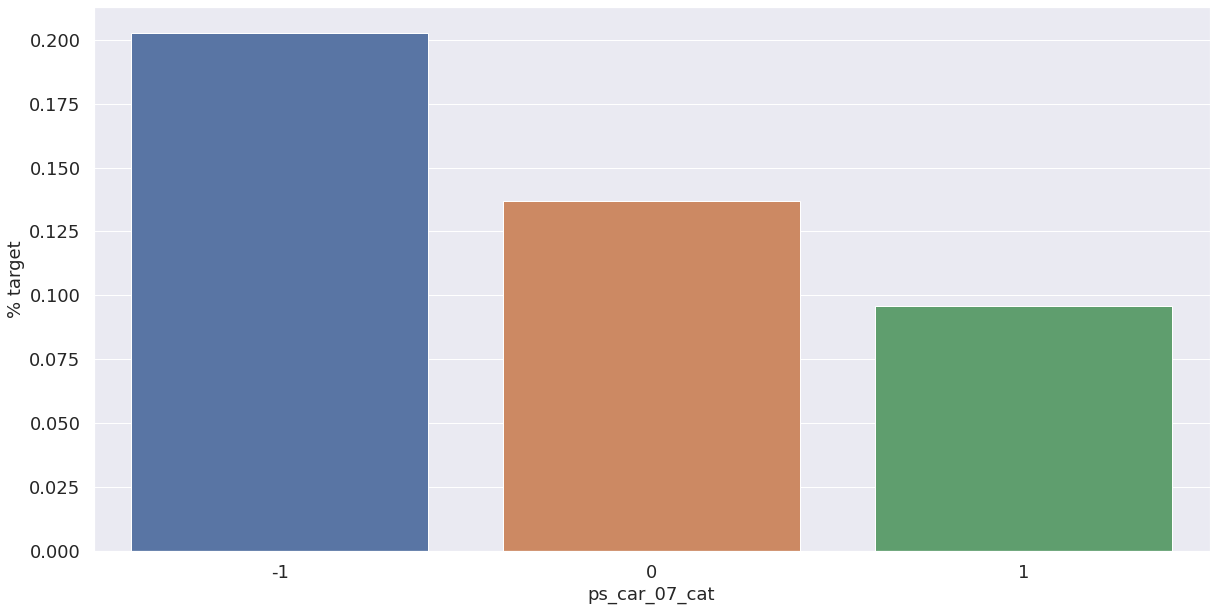

<Figure size 432x288 with 0 Axes>

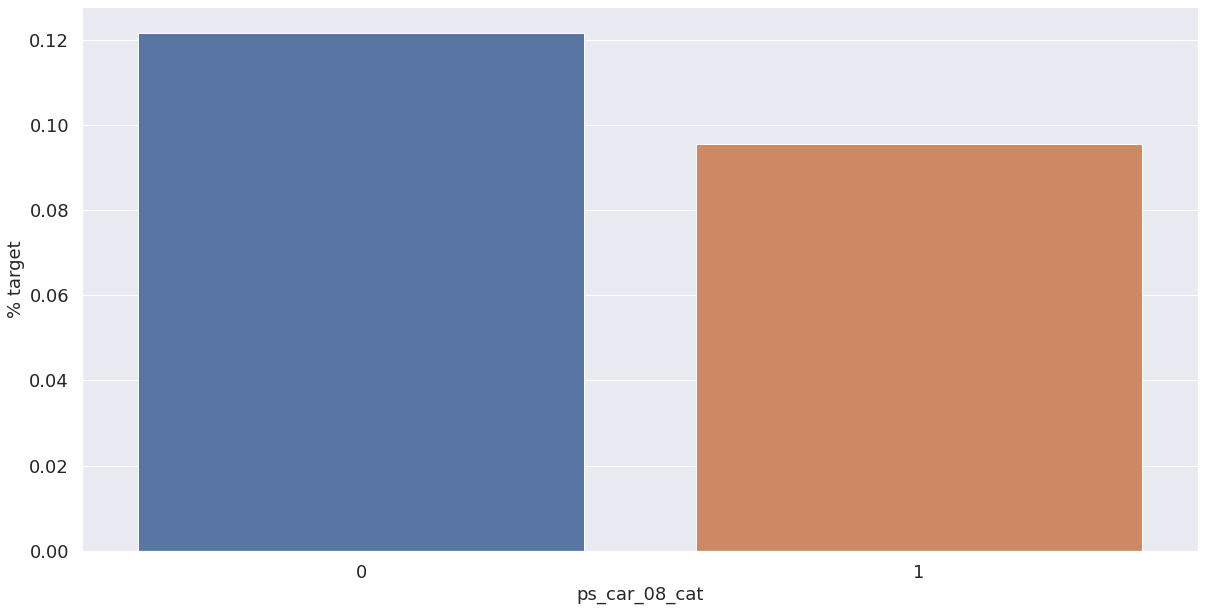

<Figure size 432x288 with 0 Axes>

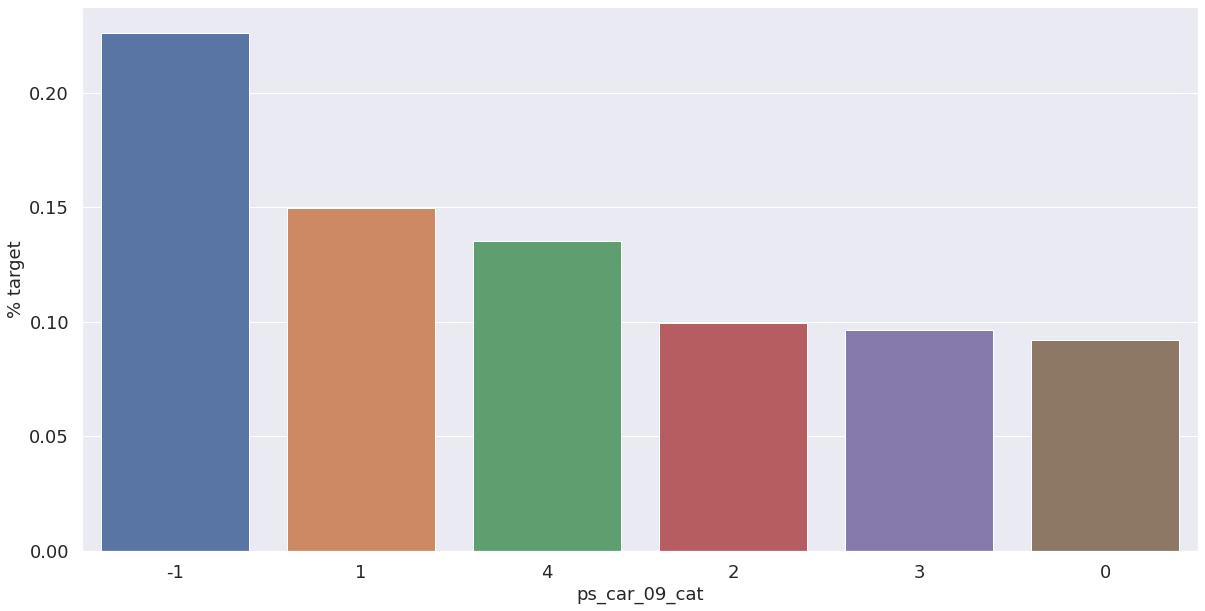

<Figure size 432x288 with 0 Axes>

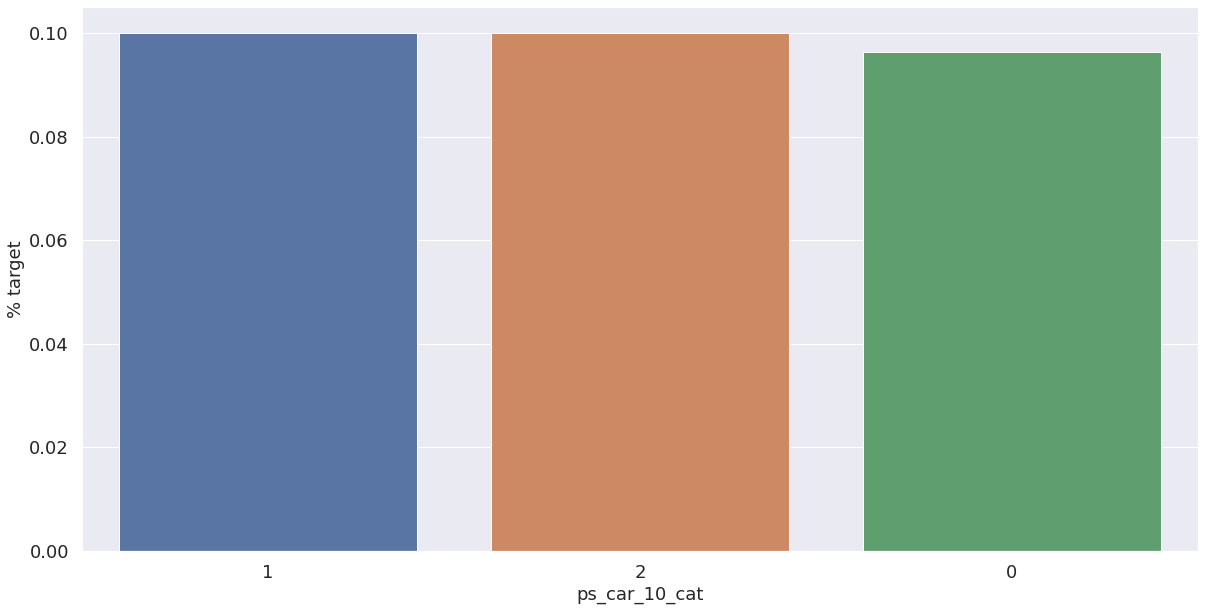

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

0.5 근처이면 좋은 지표를 주지 못합니다. 낮거나 높은 값들이 데이터에 대해 알기 좋습니다.  
좋은 결과를 반환했어도 데이터의 수를 고려해야합니다.  
결측값이있는 변수에서 볼 수 있듯이 결측값을 대체하는 대신 별도의 범주 값으로 유지하는 것이 좋습니다.  
결측값이있는 고객은 보험 청구를 요청할 가능성이 훨씬 더 높은 (경우에 따라 훨씬 더 낮은) 것으로 보입니다.

## interval variables 간격변수
interval 변수간의 상관 관계를 확인합니다. 히트맵을 사용할 것입니다.


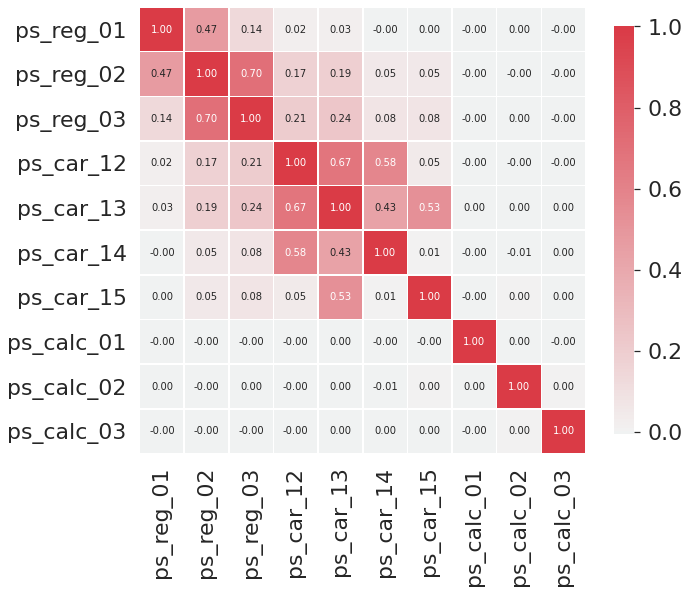

In [ ]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

변수 간에는 강력한 상관 관계가 있습니다.

ps_reg_02 및 ps_reg_03 (0.7)
ps_car_12 및 ps_car13 (0.67)
ps_car_12 및 ps_car14 (0.58)
ps_car_13 및 ps_car15 (0.67)

컬럼별로 나눠 살펴보겠습니다  
속도를 위해 train중 일부를 가져오겠습니다.


In [ ]:
s = train.sample(frac=0.1)
s.shape

(21694, 57)

두 변수간에 선형관계를 볼 수 있다.  

ps_reg_02 , ps_reg_03   


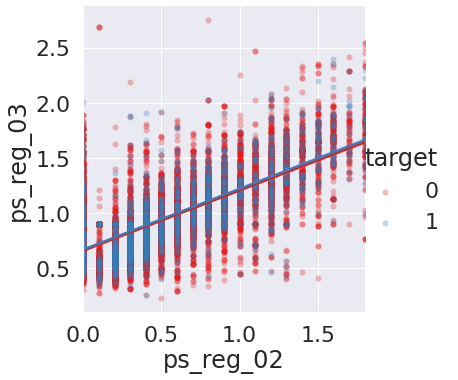

In [ ]:
sns.lmplot(x='ps_reg_02', y = 'ps_reg_03', data = s, hue = 'target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12 and ps_car_13


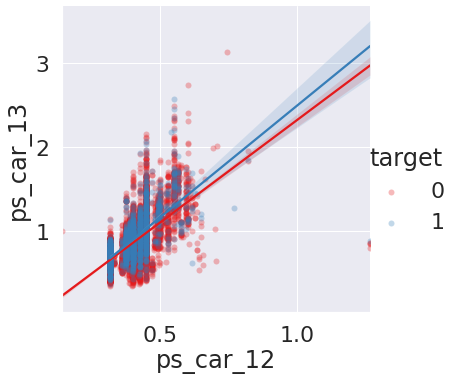

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12 and ps_car_14¶


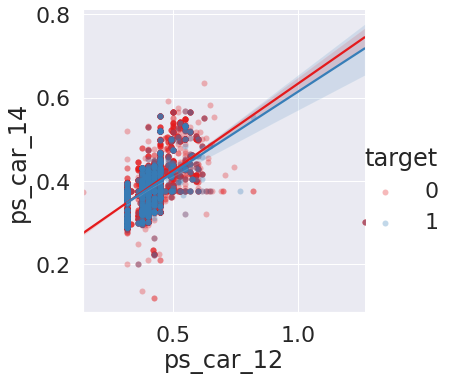

In [ ]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_13 and ps_car_15¶


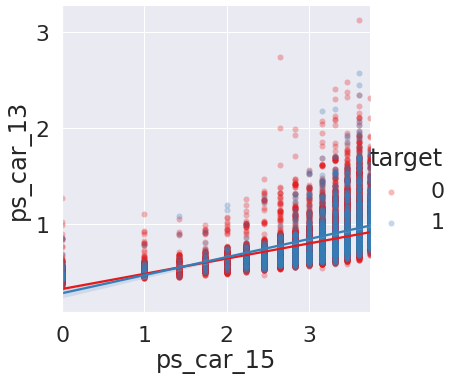

In [ ]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

유지할 상관 변수를 어떻게 결정할 수 있을까요?   
변수에 대해 PCA (주성분 분석)를 수행하여 차원을 줄일 수 있습니다   
상관 변수의 수가 적기 때문에 모델이 무거운 작업을 수행하도록 할 것입니다.

## ordinal variables 수치형 변수


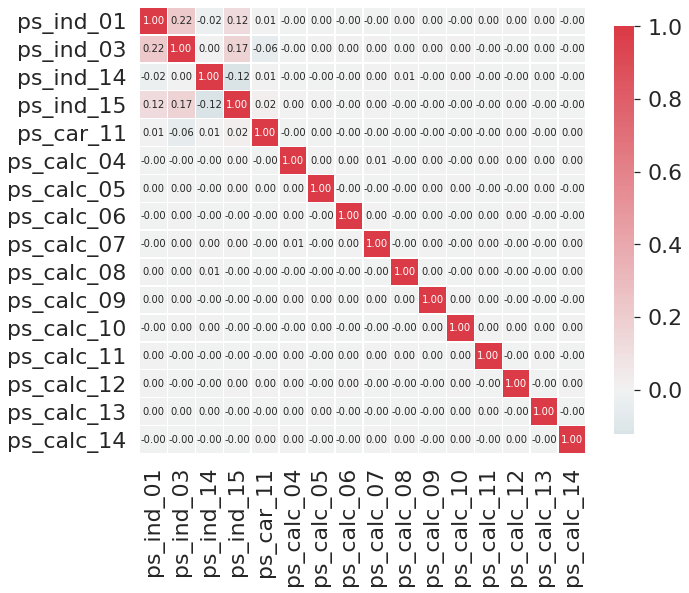

In [ ]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

순서 형 변수의 경우 상관 관계가 많지 않습니다. 반면에 목표 값으로 그룹화 할 때 분포가 어떻게되는지 볼 수 있습니다

# Feature engineering


## create dummy variables


범주 형 변수의 값은 차수 나 크기를 나타내지 않습니다. 예를 들어, 범주 2는 범주 1 값의 두 배가 아닙니다. 따라서이를 처리하기 위해 더미 변수를 만들 수 있습니다. 이 정보는 원래 변수의 범주에 대해 생성 된 다른 더미 변수에서 파생 될 수 있으므로 원래의 변수를 삭제합니다.

In [ ]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


더미 변수를 생성하면 훈련 세트에 52 개의 변수가 추가됩니다.

## createing interaction variables

In [ ]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# 상호 작용 변수를 훈련 데이터에 연결

print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train



이렇게하면 기차 데이터에 추가 상호 작용 변수가 추가됩니다. get_feature_names 메소드 덕분에 이러한 새 변수에 열 이름을 할당 할 수 있습니다.

## Feature selection


분산이 적거나없는 특성 제거  

개인적으로 저는 분류 알고리즘이 유지할 기능을 선택하도록하는 것을 선호합니다. 그러나 우리가 스스로 할 수있는 것이 한 가지 있습니다. 이는 변동이 없거나 매우 낮은 특성을 제거하는 것입니다. Sklearn에는 VarianceThreshold라는 편리한 방법이 있습니다. 기본적으로 분산이 0 인 기능을 제거합니다. 이전 단계에서 0 분산 변수가 없음을 확인 했으므로이 대회에는 적용되지 않습니다. 그러나 분산이 1 % 미만인 특성을 제거하면 31 개의 변수가 제거됩니다.

In [ ]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']



분산을 기반으로 선택하면 다소 많은 변수를 잃게됩니다. 그러나 변수가 너무 많지 않기 때문에 모델이 선택하도록 할 것입니다. 더 많은 변수가있는 데이터 세트의 경우 처리 시간을 줄일 수 있습니다.

Sklearn은 또한 다른 feature 선택 방법도 함께 제공됩니다. 이러한 메서드 중 하나는 다른 분류자가 최상의 기능을 선택하고 계속 진행하도록하는 SelectFromModel입니다. 아래에서는 Random Forest로 이를 수행하는 방법을 보여 드리겠습니다.

**Random Forest 및 SelectFromModel로 기능 선택**

여기서는 랜덤 포레스트의 기능 중요도를 기준으로 기능 선택을 할 것입니다. Sklearn의 SelectFromModel을 사용하면 유지할 변수 수를 지정할 수 있습니다. 기능 중요도 수준에 대한 임계 값을 수동으로 설정할 수 있습니다. 그러나 우리는 단순히 상위 50 % 최고의 변수를 선택합니다.

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021174
 2) ps_car_13                      0.017353
 3) ps_car_12 ps_car_13            0.017304
 4) ps_car_13^2                    0.017253
 5) ps_car_13 ps_car_14            0.017161
 6) ps_reg_03 ps_car_13            0.017084
 7) ps_car_13 ps_car_15            0.016847
 8) ps_reg_01 ps_car_13            0.016711
 9) ps_reg_03 ps_car_14            0.016230
10) ps_reg_03 ps_car_12            0.015544
11) ps_reg_03 ps_car_15            0.015182
12) ps_car_14 ps_car_15            0.015058
13) ps_car_13 ps_calc_01           0.014721
14) ps_car_13 ps_calc_02           0.014680
15) ps_reg_02 ps_car_13            0.014669
16) ps_car_13 ps_calc_03           0.014636
17) ps_reg_01 ps_reg_03            0.014635
18) ps_reg_01 ps_car_14            0.014372
19) ps_reg_03^2                    0.014274
20) ps_reg_03                      0.014238
21) ps_reg_03 ps_calc_03           0.013824
22) ps_reg_03 ps_calc_02           0.013739
23) ps_reg_03 ps_calc_01        


SelectFromModel을 사용하여 사용할 사전 적합 분류기와 기능 중요도에 대한 임계 값을 지정할 수 있습니다. get_support 메소드를 사용하면 train 데이터의 변수 수를 제한 할 수 있습니다.

In [ ]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [ ]:
train = train[selected_vars + ['target']]

### Scaling

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

결론
이 노트북이이 대회를 시작하는 방법에 대한 몇 가지 팁을 제공하기를 바랍니다. 